In [1]:


import sys
import os
import pandas as pd
# allow importing from src/
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from scripts.ReviewAnalayser import SentimentThemeAnalyzer  # or wherever you save it

from scripts.config import DATA_PATHS

df = pd.read_csv(DATA_PATHS["processed_reviews"])
ana = SentimentThemeAnalyzer(df, data_paths=DATA_PATHS)

summary = ana.run_full_pipeline(do_transformer=True, do_lexicon=True, do_topics=True)

# inspect
display(summary["aggregates"].head())
display(summary["theme_assignments"].head())


Preprocessing text...
Computing lexicon sentiment (TextBlob + VADER)...
Computing transformer sentiment using: distilbert-base-uncased-finetuned-sst-2-english


Device set to use cpu


Extracting keywords via TF-IDF per bank...
Extracting keywords via TF-IDF per bank...
Running LDA per bank...
Saved results to ../../data/processed/reviews_with_sentiment.csv


,bank_name,rating,mean_sentiment,sd_sentiment,count_reviews
0,Bank of Abyssinia,1,0.983746,0.063299,138
1,Bank of Abyssinia,2,0.947295,0.129946,13
2,Bank of Abyssinia,3,0.975188,0.067684,30
3,Bank of Abyssinia,4,0.957223,0.084425,25
4,Bank of Abyssinia,5,0.973731,0.076641,214


,bank_name,keywords,themes_matched
0,Bank of Abyssinia,"[app, good, work, bank, bad, boa, use, time, p...","[Positive Feedback, Negative Feedback]"
1,Commercial Bank of Ethiopia,"[app, good, good app, nice, cbe, work, update,...","[Positive Feedback, Transaction Performance]"
2,Dashen Bank,"[app, good, dashen, bank, use, dashen bank, ba...",[Positive Feedback]


📊 Running all visualizations...


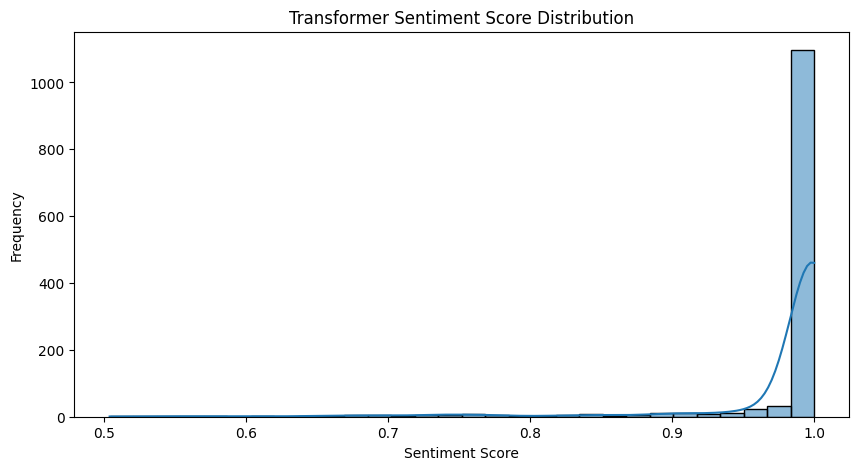

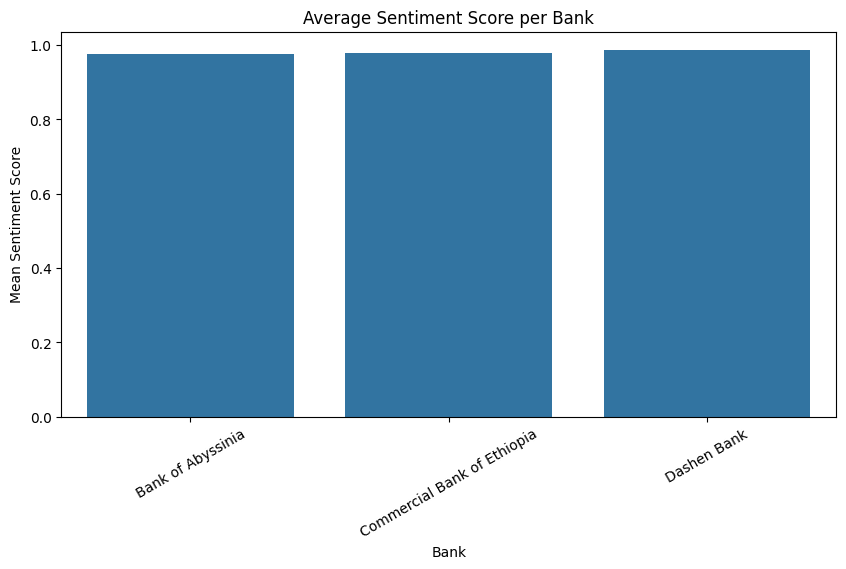

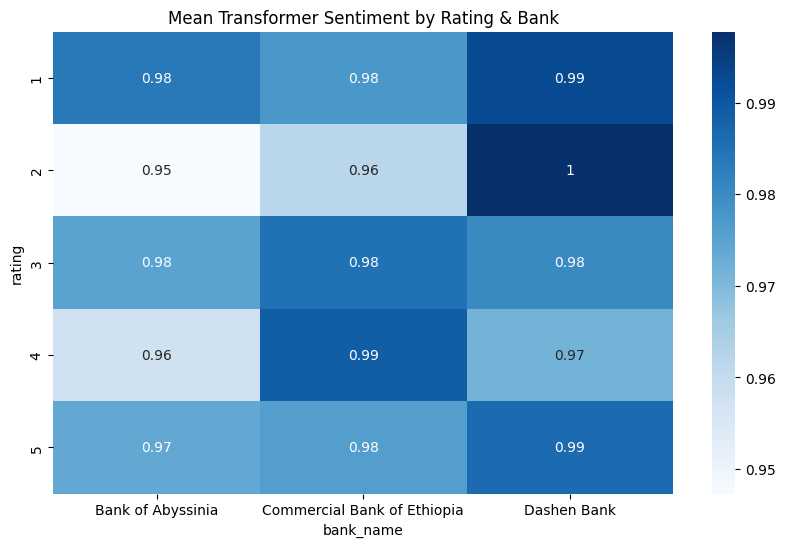

⚠ No TF-IDF keyword file found. Skipping...
⚠ Theme visual skipped: [Errno 2] No such file or directory: '../../data/processed\\theme_assignments.csv'
✅ All visualizations complete.


In [2]:
from scripts.SentimentVisualizer import SentimentVisualizer
vis = SentimentVisualizer()
vis.run_all()


In [4]:

import json
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

# Load processed reviews
df = pd.read_csv("../../data/processed/reviews_with_sentiment.csv")

# Flatten all tokens_nostop across all reviews
# tokens_nostop is stored as a string of list, convert to actual list
df['tokens_nostop_list'] = df['tokens_nostop'].apply(lambda x: eval(x) if isinstance(x, str) else [])

all_tokens = [token for tokens in df['tokens_nostop_list'] for token in tokens]

# Count frequency
token_freq = Counter(all_tokens)
top_tokens = token_freq.most_common(200)  # top 200 keywords

print("Top 20 frequent keywords across all banks:")
print(top_tokens[:20])

# -----------------------------
# TF-IDF per bank (optional)
# -----------------------------
banks = df['bank_name'].unique()
bank_keywords = {}

for bank in banks:
    subset = df[df['bank_name'] == bank]
    texts = subset['tokens_nostop_list'].apply(lambda toks: " ".join(toks)).tolist()
    if not texts:
        continue
    tfidf = TfidfVectorizer(max_features=200)
    X = tfidf.fit_transform(texts)
    features = tfidf.get_feature_names_out()
    scores = X.sum(axis=0).A1
    kw_score = sorted(zip(features, scores), key=lambda x: x[1], reverse=True)
    bank_keywords[bank] = kw_score[:50]  # top 20 per bank

# Save to JSON for inspection
with open("../../data/processed/keyword_suggestions.json", "w") as f:
    json.dump(bank_keywords, f, indent=2)

print("✅ Keyword suggestions saved to keyword_suggestions.json")


Top 20 frequent keywords across all banks:
[('app', 504), ('good', 315), ('bank', 120), ('work', 99), ('use', 94), ('nice', 76), ('banking', 69), ('update', 60), ('well', 59), ('bad', 57), ('time', 53), ('one', 51), ('application', 49), ('dashen', 47), ('like', 46), ('easy', 46), ('fast', 45), ('please', 45), ('mobile', 45), ('ever', 43)]
✅ Keyword suggestions saved to keyword_suggestions.json
